Code for Variance Hammer's Eldar Codex Review
========================
This code is for the analysis of the effect of the changes to the Wave Serpent's Serpent Shield, as well as the impact of Dire Avengers being able to Overwatch at BS 2. The text of the review itself is at: http://www.variancehammer.com/ . Note that because this analysis uses random numbers, any results you obtain may differ from those on the blog posting due to random chance.


**Import the necessary libraries**  

These are easily obtained using the Anaconda Python Distribution, which is available free from http://www.continuum.io

In [1]:
%matplotlib inline

In [74]:
import numpy as np
import random as rand
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

As there is no Variance Hammer library available (yet), we need to define a couple useful functions. *DiceRoller()* is a function to roll an arbitrary number of d6 dice. *Shooting()* does what it says on the tin - it takes a number of shots, rolls the appropriate number of d6 dice, checks those results against Ballistic Skill, and if the shots are twin-linked, rerolls as appropriate. Note that at the moment this function **does not** work for BS values above 6.

In [75]:
def DiceRoller(n_rolls):
	try:
		dice = int(n_rolls)
	except ValueError:
		print("Number of dice to roll needs to be an integer")
	rolls = np.random.random_integers(6, size=(1.,dice))
	return rolls

In [76]:
def Shooting(BS, n_shots, twinlinked):
    try:
        BS = int(BS)
    except ValueError:
        print("BS needs to be an integer")
    try:
        n_shots = int(n_shots)
    except ValueError:
        print("Number of shots needs to be an integer")
    if twinlinked == "Y":
        shots = DiceRoller(n_shots)
        shots[shots > BS] = rand.randint(1,6)
    elif twinlinked =="N":
        shots = DiceRoller(n_shots)
    else:
        print("Designate Twin-linking with Y or N. Assumed to be off.")
        shots = DiceRoller(n_shots)

    hits = np.sum(shots.__ge__(7-BS))
    return shots,hits

**Wave Serpent Changes**

Finally, we get to the actual analysis. Here, we build a function for an "old" 6th edition Wave Serpent firing both a twin-linked Scatter Laser and it's Serpent Shield for a turn, handling the twin-linking induced by Laser Lock if the Scatter Laser hits. Then we apply this for four turns worth of shooting.

The "new" 7th edition Wave Serpent needs a slightly different function, as Laser Lock is no longer a rule, and we need to know if the Serpent Shield is available to fire. Then we apply the same idea - four turns of shooting, one with the Shield firing, the others without.

Once we have those, we simulate a number of games, collect the results, and compare them using a histogram - 6th edition is in purple, and 7th edition is in Tarheel Blue.

In [5]:
def OldWS():
    ScatterLaser = Shooting(4,4,'Y')
    if ScatterLaser[1] >= 1:
        SS = Shooting(4,(rand.randint(1,6)+1),'Y')
    else:
        SS = Shooting(4,(rand.randint(1,6)+1),'N')
    Total = ScatterLaser[1] + SS[1]
    return Total

def OldWSFourTurns():
    Turn1 = OldWS()
    Turn2 = OldWS()
    Turn3 = OldWS()
    Turn4 = OldWS()
    Total = Turn1 + Turn2 + Turn3 + Turn4
    return Total

In [6]:
def NewWS(shield):
    ScatterLaser = Shooting(4,4,'Y')
    if shield == 1:
        SS = Shooting(4,(rand.randint(1,6)+rand.randint(1,6)),'N')
        Total = ScatterLaser[1] + SS[1]
    else:
        Total = ScatterLaser[1]
    return Total

def NewWSFourTurns():
    Turn1 = NewWS(shield=1)
    Turn2 = NewWS(shield=0)
    Turn3 = NewWS(shield=0)
    Turn4 = NewWS(shield=0)
    Total = Turn1 + Turn2 + Turn3 + Turn4
    return Total

In [7]:
runs = 2500

In [8]:
wscomparison = np.empty([runs,2])

In [9]:
for i in range(runs):
    wscomparison[i][0] = OldWSFourTurns()
    wscomparison[i][1] = NewWSFourTurns()

In [10]:
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8, 4)})

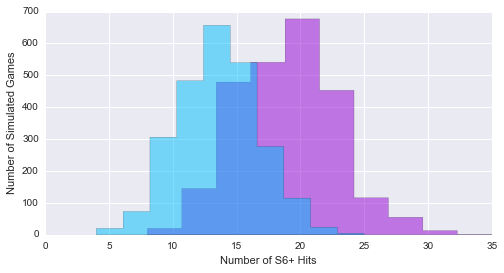

In [11]:
plt.hist(wscomparison[:,0],alpha=0.50,bins=10,color="DarkViolet",histtype="stepfilled")
plt.hist(wscomparison[:,1],alpha=0.50,bins=10,color="DeepSkyBlue",histtype="stepfilled")
plt.xlabel("Number of S6+ Hits")
plt.ylabel("Number of Simulated Games")

**Wave Serpent AA Fire**

This analysis isn't terribly difficult - just the same analysis for a single turn, with an assumed BS of 1.

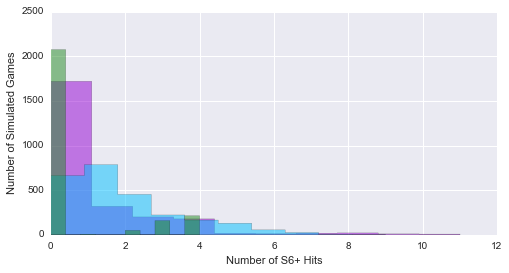

In [12]:
def OldWSAA():
    ScatterLaser = Shooting(1,4,'Y')
    if ScatterLaser[1] >= 1:
        SS = Shooting(1,(rand.randint(1,6)+1),'Y')
    else:
        SS = Shooting(1,(rand.randint(1,6)+1),'N')
    Total = ScatterLaser[1] + SS[1]
    return Total

def NewWSAA(shield):
    ScatterLaser = Shooting(1,4,'Y')
    if shield == 1:
        SS = Shooting(1,(rand.randint(1,6)+rand.randint(1,6)),'N')
        Total = ScatterLaser[1] + SS[1]
    else:
        Total = ScatterLaser[1]
    return Total

aa = np.empty([runs,3])
for j in range(runs):
    aa[j][0] = OldWSAA()
    aa[j][1] = NewWSAA(shield=1)
    aa[j][2] = NewWSAA(shield=0)

plt.hist(aa[:,0],alpha=0.50,color="DarkViolet",histtype="stepfilled")
plt.hist(aa[:,1],alpha=0.50,color="DeepSkyBlue",histtype="stepfilled")
plt.hist(aa[:,2],alpha=0.50,color="ForestGreen",histtype="stepfilled")
plt.xlabel("Number of S6+ Hits")
plt.ylabel("Number of Simulated Games")

** Sustained AA Fire **

How does the situation look with two turns of shooting?

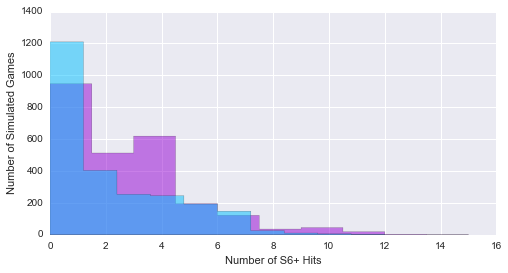

In [13]:
def OldWSDoubleAA():
    Turn1 = OldWSAA()
    Turn2 = OldWSAA()
    Total = Turn1 + Turn2
    return Total
def NewWSDoubleAA():
    Turn1 = NewWSAA(shield=1)
    Turn2 = NewWSAA(shield=0)
    Total = Turn1 + Turn2
    return Total
sustainedaa = np.empty([runs,2])
for m in range(runs):
    sustainedaa[m][0] = OldWSDoubleAA()
    sustainedaa[m][1] = NewWSDoubleAA()
plt.hist(sustainedaa[:,0],alpha=0.50,color="DarkViolet",histtype="stepfilled")
plt.hist(sustainedaa[:,1],alpha=0.50,color="DeepSkyBlue",histtype="stepfilled")
plt.xlabel("Number of S6+ Hits")
plt.ylabel("Number of Simulated Games")

**Dire Avenger BS 2 Overwatch**

This analysis is actually much easier, as it's just two sets of shooting, one at BS1, the other at BS2. Again, we use a histogram to visualize the difference in the two distributions.

In [14]:
overwatch = np.empty([runs,2])

In [15]:
for k in range(runs):
    overwatch[k][0] = Shooting(1,10,'N')[1]
    overwatch[k][1] = Shooting(2,10,'N')[1]

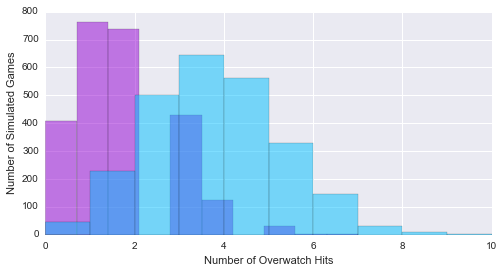

In [16]:
plt.hist(overwatch[:,0],bins=10,alpha=0.50,color="DarkViolet")
plt.hist(overwatch[:,1],bins=10,alpha=0.50,color="DeepSkyBlue")
plt.xlabel("Number of Overwatch Hits")
plt.ylabel("Number of Simulated Games")

But what about Counter-attack? Lets expand that overwatch out to a full turn of close combat - overwatch, plus the first round of hits. We're going to cheat a bit and use the shooting function, just engineered to give 4+ hits, which is probably what the Dire Avengers will be doing in close combat. There are 11 close combat attacks (2 * 5 Dire Avengers + Exarch attack) with Counter-attack, and 6 without.

In [17]:
avengercc = np.empty([runs,2])
def daccBS1():
    overwatch = Shooting(1,10,'N')[1]
    closecombat = Shooting(3,11,'N')[1]
    total = overwatch + closecombat
    return total
def daccBS2():
    overwatch = Shooting(2,10,'N')[1]
    closecombat = Shooting(3,6,'N')[1]
    total = overwatch + closecombat
    return total

for n in range(runs):
    avengercc[n][0] = daccBS1()
    avengercc[n][1] = daccBS2()
    

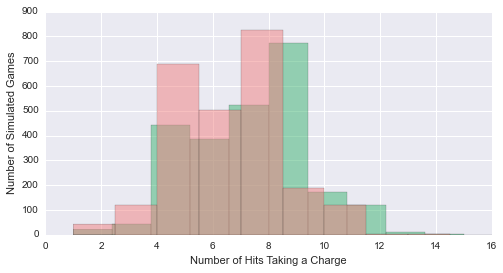

In [18]:
plt.hist(avengercc[:,0],bins=10,alpha=0.50,color="MediumSeaGreen")
plt.hist(avengercc[:,1],bins=10,alpha=0.50,color="LightCoral")
plt.xlabel("Number of Hits Taking a Charge")
plt.ylabel("Number of Simulated Games")

**Windrider Jetbikes**

Analyzing the impact of the windriders, as compared to old style Serpent Spam. Just how many windrider jetbikes does it need to restore that same amount of shooting? We'll borrow the old four turns of shooting function from earlier, and then see how many jetbikes are needed to push a new Wave Serpent + some Jetbikes into looking like an old Wave Serpent, assuming they're using Scatter Lasers.

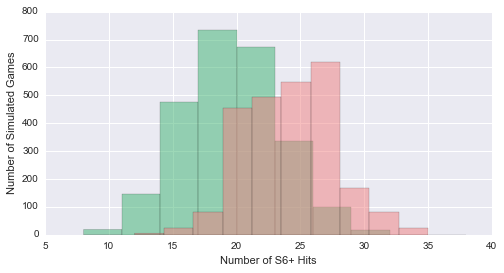

In [19]:
def WSScatBikesFourTurns():
    Turn1 = NewWS(shield=1)+ Shooting(4,4,'N')[1]
    Turn2 = NewWS(shield=0)+ Shooting(4,4,'N')[1]
    Turn3 = NewWS(shield=0)+ Shooting(4,4,'N')[1]
    Turn4 = NewWS(shield=0)+ Shooting(4,4,'N')[1]
    Total = Turn1 + Turn2 + Turn3 + Turn4
    return Total

windriders = np.empty([runs,2])

for w in range(runs):
    windriders[w][0] = OldWSFourTurns()
    windriders[w][1] = WSScatBikesFourTurns()

plt.hist(windriders[:,0],bins=10,alpha=0.50,color="MediumSeaGreen")
plt.hist(windriders[:,1],bins=10,alpha=0.50,color="LightCoral")
plt.xlabel("Number of S6+ Hits")
plt.ylabel("Number of Simulated Games")

** Wrathguard Analysis **

Here I explore the idea that there's a particular "D-threat Range", rather than merely Ranged versus Melee Strength D weapons. This is done by comparing the results of a Battle Focus-ranged Wrathguard unit versus the move-and-charge range of an Imperial Knight. We'll assume the Wrathguard unit is close enough to a Spirit Seer to *be* Battle Focused.

In [20]:
dthreat = np.empty([runs,2])

def WrathMoveShoot():
    # 6" move + d6 Run + 12" range Wrathcannon
    distance = 6 + 12 + rand.randint(1,6)
    return distance

def KnightMoveCharge():
    # 12" move + 2d6 Charge
    distance = 12 + rand.randint(1,6) + rand.randint(1,6)
    return distance

for d in range(runs):
    dthreat[d][0] = WrathMoveShoot()
    dthreat[d][1] = KnightMoveCharge()

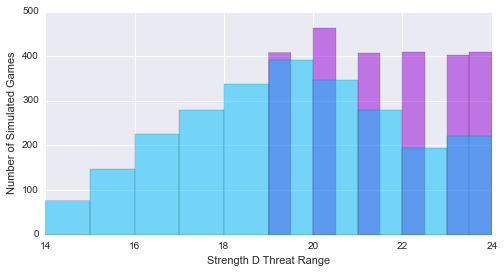

In [21]:
plt.hist(dthreat[:,0],bins=10,alpha=0.50,color="DarkViolet")
plt.hist(dthreat[:,1],bins=10,alpha=0.50,color="DeepSkyBlue")
plt.xlabel("Strength D Threat Range")
plt.ylabel("Number of Simulated Games")

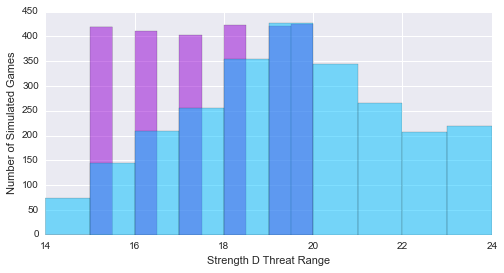

In [22]:
def DFlamerMoveShoot():
    # 6" move + d6 Run + 8" range Wrathcannon
    distance = 6 + 8 + rand.randint(1,6)
    return distance

dthreat2 = np.empty([runs,2])

for e in range(runs):
    dthreat2[e][0] = DFlamerMoveShoot()
    dthreat2[e][1] = KnightMoveCharge()

plt.hist(dthreat2[:,0],bins=10,alpha=0.50,color="DarkViolet")
plt.hist(dthreat2[:,1],bins=10,alpha=0.50,color="DeepSkyBlue")
plt.xlabel("Strength D Threat Range")
plt.ylabel("Number of Simulated Games")

In [23]:
#35/257 = 13.6%

To properly look at the impact of changing *Distort* weapons from whatever they once were to Strength D, we need to model not only the number of hits, but the number of wounds done. Which means a new function. And a fairly complex one because of the nested branching that the to-wound roll with and without Strength D. We'll also need a function to look at hits to tanks and other vehicles.

In [273]:
# SAVE MUST BE MANUALLY SET - NOT AUTO-DETERMINED BY Save vs. AP
def Wounding(strength,toughness,save,n_hits,woundspermodel,auto):
    try:
        toughness = int(toughness)
    except ValueError:
        print("Target toughness needs to be an integer")
    try:
        save = int(save)
    except ValueError:
        print("Save needs to be an integer (e.g. 3+ = 3)")
    try:
        n_hits = int(n_hits)
    except ValueError:
        print("The number of hits needs to be an integer")
    if strength == "D":
        pass
    elif strength == "D-1":
        pass
    else:
        try:
            strength = int(strength)
        except ValueError:
            print("Strength must be an integer or D")

    woundrolls = DiceRoller(n_hits)
    
    if auto == 0:
        if strength == "D":
            NoSaveD = np.sum(woundrolls==6)
            SaveD = np.sum(1<woundrolls) - NoSaveD
            saverolls = DiceRoller(SaveD)
            unsaved = np.sum(saverolls<save)
            unsaved_expanded = 0
            for k in range(unsaved):
                unsaved_expanded = unsaved_expanded + min(woundspermodel,rand.randint(1,3))
            for j in range(NoSaveD):
                unsaved_expanded = unsaved_expanded + min(woundspermodel,(rand.randint(1,6)+6))
            finalwounds = unsaved_expanded
        elif strength == "D-1":
            SaveD = np.sum(2<woundrolls)
            saverolls = DiceRoller(SaveD)
            unsaved = np.sum(saverolls<save)
            unsaved_expanded = 0
            for k in range(unsaved):
                unsaved_expanded = unsaved_expanded + min(woundspermodel,rand.randint(1,3))
            finalwounds = unsaved_expanded
        
        else:
            SvTDiff = strength-toughness
            ToWound = max(2,4-SvTDiff)
            wounds = np.sum(woundrolls.__ge__(ToWound))
            saverolls = DiceRoller(wounds)
            unsaved = np.sum(saverolls<(save))
            finalwounds = unsaved
            
    else:
        if strength == "D":
            NoSaveD = np.sum(woundrolls==6)
            SaveD = np.sum(1<woundrolls) - NoSaveD
            saverolls = DiceRoller(SaveD)
            unsaved = np.sum(saverolls<save)
            unsaved_expanded = 0
            for k in range(unsaved):
                unsaved_expanded = unsaved_expanded + min(woundspermodel,rand.randint(1,3))
            for j in range(NoSaveD):
                unsaved_expanded = unsaved_expanded + min(woundspermodel,(rand.randint(1,6)+6))
            finalwounds = unsaved_expanded
        elif strength == "D-1":
            SaveD = np.sum(2<woundrolls)
            saverolls = DiceRoller(SaveD)
            unsaved = np.sum(saverolls<save)
            unsaved_expanded = 0
            for k in range(unsaved):
                unsaved_expanded = unsaved_expanded + min(woundspermodel,rand.randint(1,3))
            finalwounds = unsaved_expanded
        
        else:
            SvTDiff = strength-toughness
            autowounds = np.sum(woundrolls>=auto)
            ToWound = max(2,4-SvTDiff)
            wounds = np.sum(woundrolls.__ge__(ToWound))
            if ToWound > 6:
                truewounds = autowounds
            else:
                truewounds = wounds
            saverolls = DiceRoller(truewounds)
            unsaved = np.sum(saverolls<(save))
            finalwounds = unsaved
        
    return finalwounds

def ArmorPen(strength,AV,save,n_hits,hullpoints):
    try:
        AV = int(AV)
    except ValueError:
        print("Target Armor Value needs to be an integer")
    try:
        save = int(save)
    except ValueError:
        print("Save needs to be an integer (e.g. 3+ = 3)")
    try:
        n_hits = int(n_hits)
    except ValueError:
        print("The number of hits needs to be an integer")
    if strength == "D":
        pass
    else:
        try:
            strength = int(strength)
        except ValueError:
            print("Strength must be an integer or D")
    
    if strength == "D":
        penrolls = DiceRoller(n_hits)
        NoSaveD = np.sum(penrolls==6)
        SaveD = np.sum(1<penrolls) - NoSaveD
        saverolls = DiceRoller(SaveD)
        unsaved = np.sum(saverolls<save)
        unsaved_expanded = 0
        for k in range(unsaved):
            unsaved_expanded = unsaved_expanded + min(hullpoints,rand.randint(1,3))
        for j in range(NoSaveD):
            unsaved_expanded = unsaved_expanded + min(hullpoints,(rand.randint(1,6)+6))
        final = min(hullpoints,unsaved_expanded)
    else:
        penrolls = DiceRoller(n_hits) + strength
        pen_and_glance = np.sum(penrolls.__ge__(AV))
        glances = np.sum(penrolls==AV)
        pens = pen_and_glance - glances
        saverolls = DiceRoller(pen_and_glance)
        unsaved = np.sum(saverolls<(save))
        final = min(hullpoints,unsaved)
        
    return final

In [276]:
def OldWrathguardInfantry(size,enemyT,enemySave,enemyW):
    WrathcannonShots = Shooting(4,size,'N')[1]
    WrathcannonWounds = Wounding(10,enemyT,enemySave,WrathcannonShots,enemyW,auto=6)
    return WrathcannonWounds

def NewWrathguardInfantry(size,enemyT,enemySave,enemyW):
    WrathcannonShots = Shooting(4,size,'N')[1]
    WrathcannonWounds = Wounding("D",enemyT,enemySave,WrathcannonShots,enemyW,auto=0)
    return WrathcannonWounds

def OldDscythe(size,enemyT,enemySave,enemyW):
    WrathcannonShots = Shooting(4,size,'N')[1]
    WrathcannonWounds = Wounding(4,enemyT,enemySave,WrathcannonShots,enemyW,auto=6)
    return WrathcannonWounds

def NewDscythe(size,enemyT,enemySave,enemyW):
    WrathcannonShots = Shooting(4,size,'N')[1]
    WrathcannonWounds = Wounding("D-1",enemyT,enemySave,WrathcannonShots,enemyW,auto=0)
    return WrathcannonWounds

def OldWrathguardTank(size,AV,enemySave,HP):
    WrathcannonShots = Shooting(4,size,'N')[1]
    WrathcannonGorP = ArmorPen(10,AV,enemySave,WrathcannonShots,HP,auto=6)
    return WrathcannonGorP

def NewWrathguardTank(size,AV,enemySave,HP):
    WrathcannonShots = Shooting(4,size,'N')[1]
    WrathcannonGorP = ArmorPen("D",AV,enemySave,WrathcannonShots,HP,auto=0)
    return WrathcannonGorP

**Examining new vs. Old Wrathguard armed with Wrathcannons.**

versus Space Marines. Save of "7" implies no save vs. AP 2 shots.

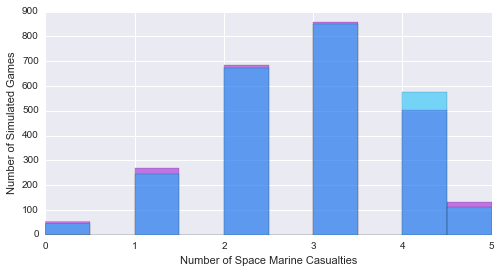

In [277]:
WrathcannonVMarines = np.empty([runs,2])

for f in range(runs):
    WrathcannonVMarines[f][0] = OldWrathguardInfantry(5,4,7,1)
    WrathcannonVMarines[f][1] = NewWrathguardInfantry(5,4,7,1)
    
plt.hist(WrathcannonVMarines[:,0],bins=10,alpha=0.50,color="DarkViolet")
plt.hist(WrathcannonVMarines[:,1],bins=10,alpha=0.50,color="DeepSkyBlue")
plt.xlabel("Number of Space Marine Casualties")
plt.ylabel("Number of Simulated Games")

versus two Talos-esq Monsterous Creatures, each with T7 and 3 Wounds. Again, save of 7 implies no save vs. AP 2.

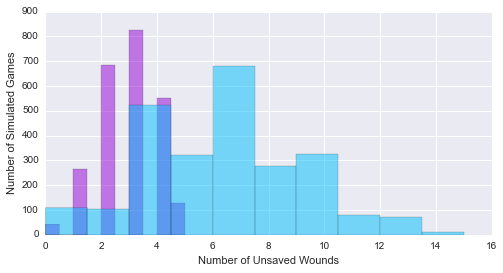

In [228]:
WrathcannonVMC = np.empty([runs,2])

for g in range(runs):
    WrathcannonVMC[g][0] = OldWrathguardInfantry(5,7,7,3)
    WrathcannonVMC[g][1] = NewWrathguardInfantry(5,7,7,3)

plt.hist(WrathcannonVMC[:,0],bins=10,alpha=0.50,color="DarkViolet")
plt.hist(WrathcannonVMC[:,1],bins=10,alpha=0.50,color="DeepSkyBlue")
plt.xlabel("Number of Unsaved Wounds")
plt.ylabel("Number of Simulated Games")

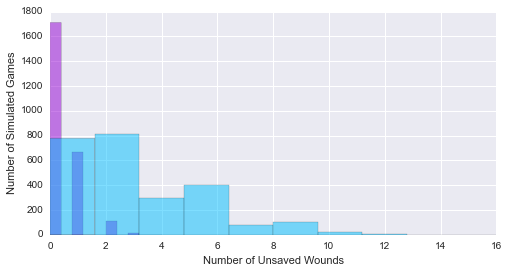

In [278]:
WrathcannonVMC2 = np.empty([runs,2])

for gg in range(runs):
    WrathcannonVMC2[gg][0] = OldDscythe(10,7,3,3)
    WrathcannonVMC2[gg][1] = NewDscythe(10,7,3,3)

plt.hist(WrathcannonVMC2[:,0],bins=10,alpha=0.50,color="DarkViolet")
plt.hist(WrathcannonVMC2[:,1],bins=10,alpha=0.50,color="DeepSkyBlue")
plt.xlabel("Number of Unsaved Wounds")
plt.ylabel("Number of Simulated Games")

In [272]:


a = Wounding2(4,10,7,10,3,auto=6)
print a
#def OldDscythe2(size,enemyT,enemySave,enemyW):
#    WrathcannonShots = Shooting(4,size,'N')[1]
#    WrathcannonWounds = Wounding(4,enemyT,enemySave,WrathcannonShots,enemyW,auto=2)
#    return WrathcannonShots,WrathcannonWounds

#a = OldDscythe2(10,7,3,3)
#print a

#b = Wounding(4,10,7,10,3,auto=2)
#print b

(10, array([[4, 4, 3, 3, 1, 6, 1, 5, 3, 4]]), 1, 0, 1, array([[4]]), 1)


Now we'll compare the two units versus two types of tanks - something Chimera-esq, and something Land Raider-esq, neither one of which has a save. Note that here we are just looking at hull point damage, rather than the effect of penetrating hits.

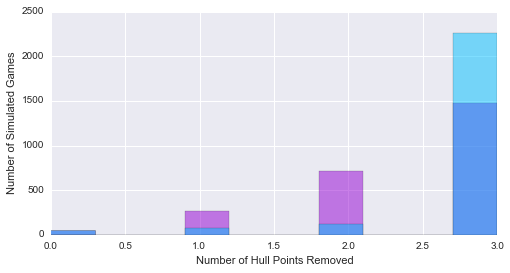

In [197]:
WrathcannonVChimera = np.empty([runs,2])

for h in range(runs):
    WrathcannonVChimera[h][0] = OldWrathguardTank(5,12,7,3)
    WrathcannonVChimera[h][1] = NewWrathguardTank(5,12,7,3)

plt.hist(WrathcannonVChimera[:,0],bins=10,alpha=0.50,color="DarkViolet")
plt.hist(WrathcannonVChimera[:,1],bins=10,alpha=0.50,color="DeepSkyBlue")
plt.xlabel("Number of Hull Points Removed")
plt.ylabel("Number of Simulated Games")

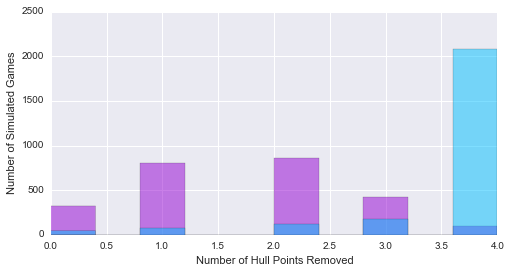

In [196]:
WrathcannonVLR = np.empty([runs,2])

for o in range(runs):
    WrathcannonVLR[o][0] = OldWrathguardTank(5,14,7,4)
    WrathcannonVLR[o][1] = NewWrathguardTank(5,14,7,4)

plt.hist(WrathcannonVLR[:,0],bins=10,alpha=0.50,color="DarkViolet")
plt.hist(WrathcannonVLR[:,1],bins=10,alpha=0.50,color="DeepSkyBlue")
plt.xlabel("Number of Hull Points Removed")
plt.ylabel("Number of Simulated Games")